# TheClairvoyantConstructor
Forecasting Prices of Core Construction Materials

### Insight Data challenge 1C

### Background

Given information on the pricing information (per unit, in dollars) for a company’s past purchases of plywood, sheetrock, steel beams, rebar, and glass contracts over the past ten years.Currently, the company is able to purchase futures contracts in a material for up to six months in advance. The challenge is forecasting the price of each commodity up to six months into the future. In particular, it would be really useful to understand when a commodity price is about to increase temporarily, in order to either buy the commodity early or wait until after the temporary increase. 


### Executive summary:
1. Price of rebar and steel tend to go down during the 2nd and 3rd quarter and peaks towards the end and beginning of year.So, that would be an ideal time to make purchases. Glass has a steady upward and downward trend every couple of months. Concrete and plywood are lowest around 7th-9th months.

2. Price of plywood seems to increase steadily in the next 6 months.

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from datetime import datetime
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [128]:
# Read the data while transforming dates to datetime
data=pd.read_csv("../construction_material_prices_2008_2018.csv",index_col=["Unnamed: 0"],parse_dates=["Unnamed: 0"])
data.head()

price_steel  price_rebar  price_glass  price_concrete  \
2007-01-01          NaN          NaN          NaN             NaN   
2007-01-03          NaN          NaN          NaN             NaN   
2007-01-04          NaN          NaN          NaN             NaN   
2007-01-05          NaN          NaN          NaN             NaN   
2007-01-08          NaN          NaN          NaN             NaN   

            price_plywood  
2007-01-01            NaN  
2007-01-03            NaN  
2007-01-04            NaN  
2007-01-05            NaN  
2007-01-08            NaN

It is a univariate time series forecasting problem.

## Descriptive statistics:


In [129]:
data.describe()

price_steel  price_rebar  price_glass  price_concrete  price_plywood
count  2309.000000  1649.000000  1472.000000     1447.000000    2673.000000
mean     12.611319    18.306339    29.997962       26.000636      12.775067
std       6.038862     8.587938     6.524622        7.314764       3.931698
min       3.062500     3.000000    16.000000       10.416667       5.000000
25%       8.500000    12.071429    25.000000       20.559028      10.125000
50%      10.500000    16.500000    29.000000       25.043478      12.125000
75%      14.833333    22.500000    35.000000       30.000000      14.333333
max      41.000000    55.000000    48.000000       50.000000      34.000000

Average price of glass and concrete is highest among all. Except plywood, price of rest of the components fluctuate significantly (SD>6) 

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2945 entries, 2007-01-01 to 2018-06-19
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_steel     2309 non-null   float64
 1   price_rebar     1649 non-null   float64
 2   price_glass     1472 non-null   float64
 3   price_concrete  1447 non-null   float64
 4   price_plywood   2673 non-null   float64
dtypes: float64(5)
memory usage: 138.0+ KB


There are 2945 records with missing values in data

In [131]:
#Drop all instances with null in all columns
data.dropna(how='all', inplace=True)
#Check percent of missing values in remaining
data.isna().mean().round(4)*100

price_steel       15.58
price_rebar       39.71
price_glass       46.18
price_concrete    47.09
price_plywood      2.27
dtype: float64

Glass, rebar and concrete have very high missing values (>39%). Imputing of any form would introduce biasness to forecasting. Before choosing the method to fill missing values, it is important to check for patterns and seasonality in the data.

In [132]:
#Renaming columns after resetting the index and retransform to datetime)
data=data.reset_index()
data=data.rename(columns={"index":"Date"})
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2735 entries, 0 to 2734
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            2735 non-null   datetime64[ns]
 1   price_steel     2309 non-null   float64       
 2   price_rebar     1649 non-null   float64       
 3   price_glass     1472 non-null   float64       
 4   price_concrete  1447 non-null   float64       
 5   price_plywood   2673 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 128.3 KB


## Examining trend, seasonality, white-noise  
If we decompose the time series data with linear regression model, it is:
   Yt=mt+st+ϵt
where mt stands for trend, st stands for seasonality, and ϵt stands for random variables

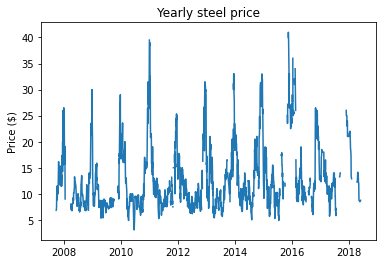

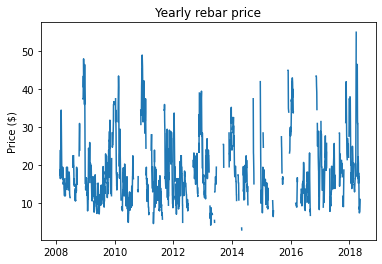

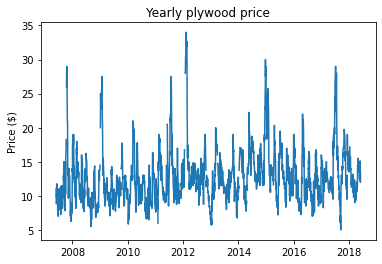

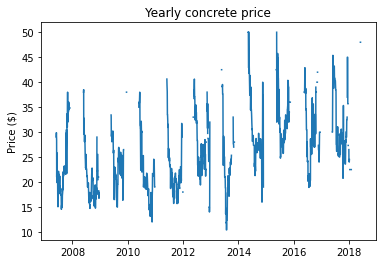

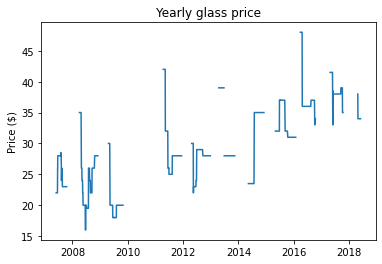

In [133]:
def trend_plot(x, y, title):
    plt.plot(x, y)
    plt.title(title)
    plt.ylabel('Price ($)');
    plt.show()
    
# y=[[data.price_steel,'Yearly steel price'],[data.price_rebar,'Yearly rebar price'],[data.price_plywood,'Yearly plywood price'],[data.price_glass,'Yearly glass price'] ]
# for i, title in y:
#     trend_plot(data.Date,y,title)
x=data.Date
y=data.price_steel
title='Yearly steel price'
b=data.price_rebar
c='Yearly rebar price'
m=data.price_plywood
n='Yearly plywood price'
o=data.price_concrete
p='Yearly concrete price'
q=data.price_glass
r='Yearly glass price'


trend_plot(x,y,title)
trend_plot(x,b,c)
trend_plot(x,m,n)
trend_plot(x,o,p)
trend_plot(x,q,r)

#### Yearly price of steel has some seasonality/cyclical behaviour 
Values peaking around end and beginning of a year.

#### Upward trend for glass price and concrete price. 
However, it is not clear as ~47% data is missing. But looks like the price have shot up in the last 2-3 years.

In [134]:
#Reset date as index
data=data.set_index("Date")

## Dealing with missing values:
Linear interpolation

In [135]:
col=data.columns
for i in col:
#     print(data[i])
   data[i].interpolate(method='time', inplace=True)
data.isna().sum()

price_steel        76
price_rebar       144
price_glass         0
price_concrete      0
price_plywood       0
dtype: int64

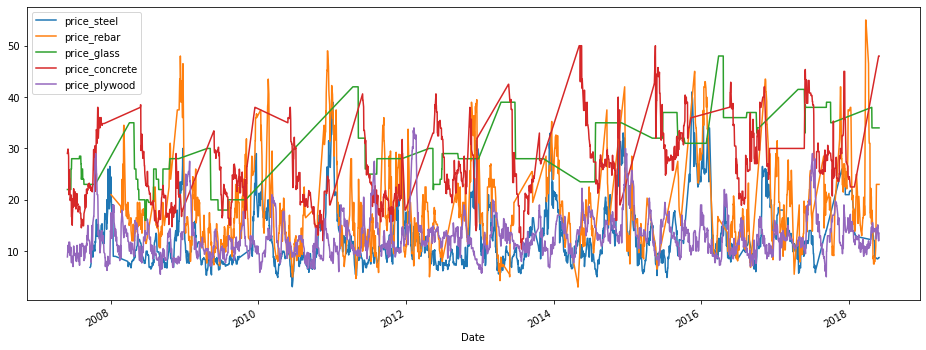

In [136]:
data.plot(figsize = (16,6))

Not all missing datapoints have been filled in steel and rebar. Since it is a univariate time series, will drop any remaining null values.
From the figure, it is clear, that for glass and concrete, it is not an optimum solution to deal with the missing values. For time constraint, will not try other methods now. 

In [138]:
data=data.dropna()
data.isna().sum()

price_steel       0
price_rebar       0
price_glass       0
price_concrete    0
price_plywood     0
dtype: int64

# Exploratory Data Analysis:


### Moving-average:
The initial plots don't clearly suggest if there is some seasonality in the data.Using moving average to smooth our time series by using a helper function that will run the moving average model on a specified time window and it will plot the result smoothed curve:
Let’s see the result of smoothing by the previous month, and previous quarter.
Reference:https://towardsdatascience.com/end-to-end-time-series-analysis-and-modelling-8c34f09a3014

In [139]:
#Create a MA function
def plot_moving_average(series, window, plot_intervals=False, scale=2):
    '''
    Function to calculate moving average
    Arg. Series, window, plot_intervals, scale
    '''
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,10))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'red', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    
    plt.legend(loc='best')
    plt.grid(True)


price_steel
price_rebar
price_glass
price_concrete
price_plywood


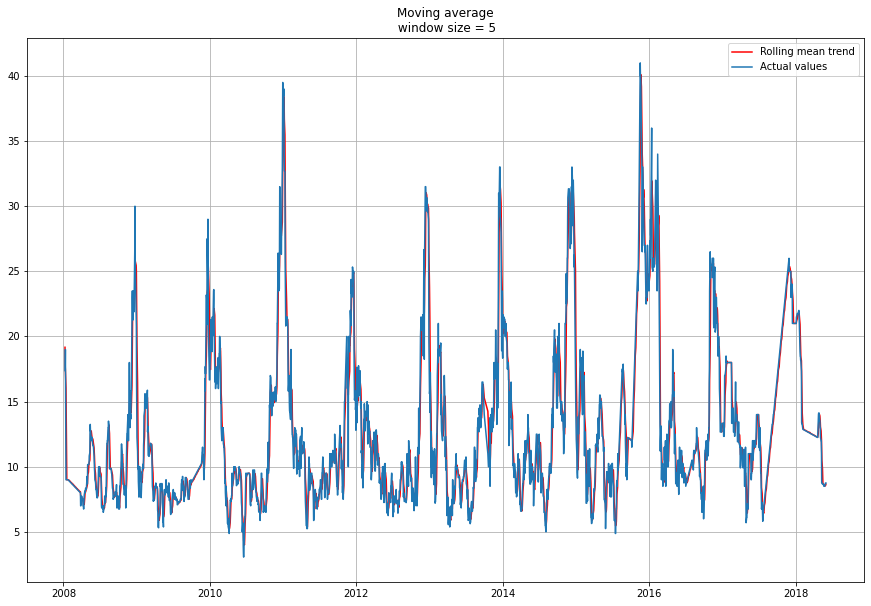

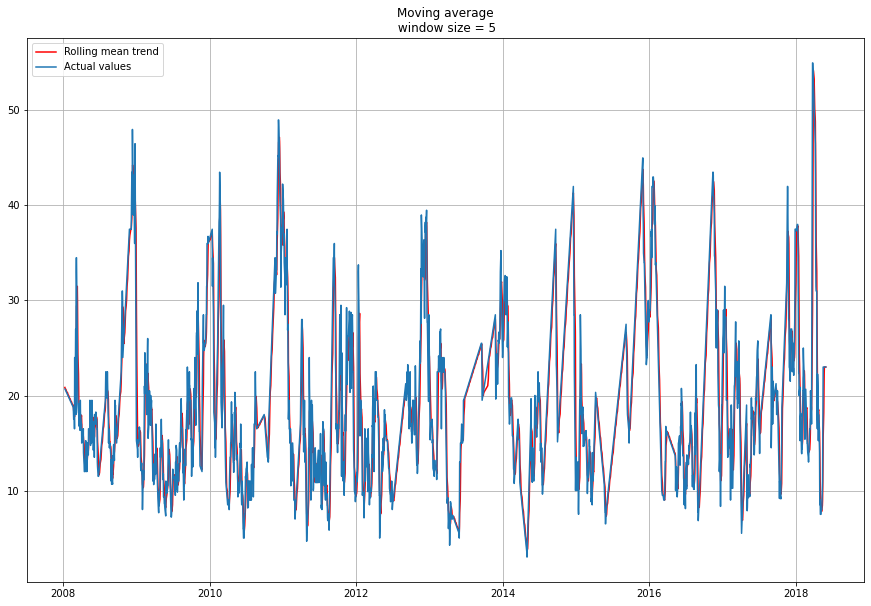

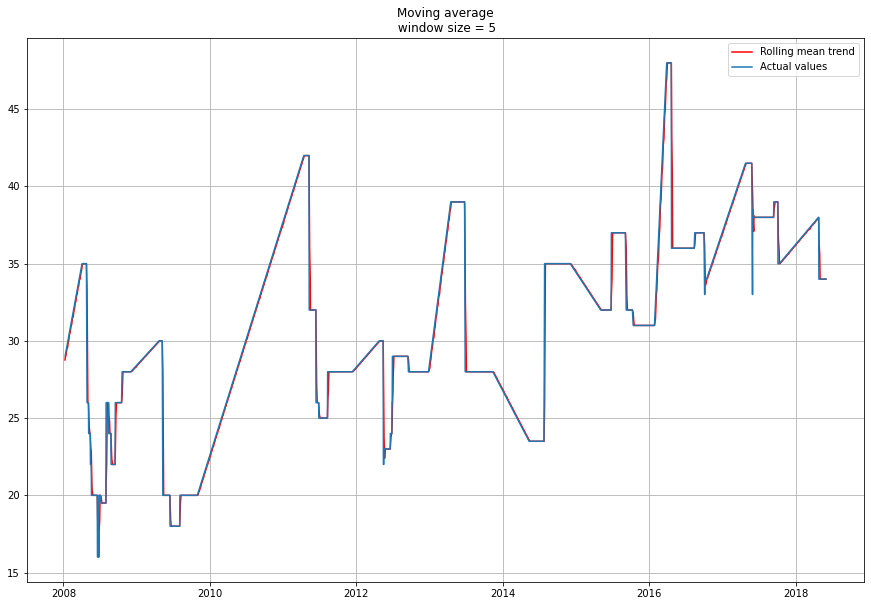

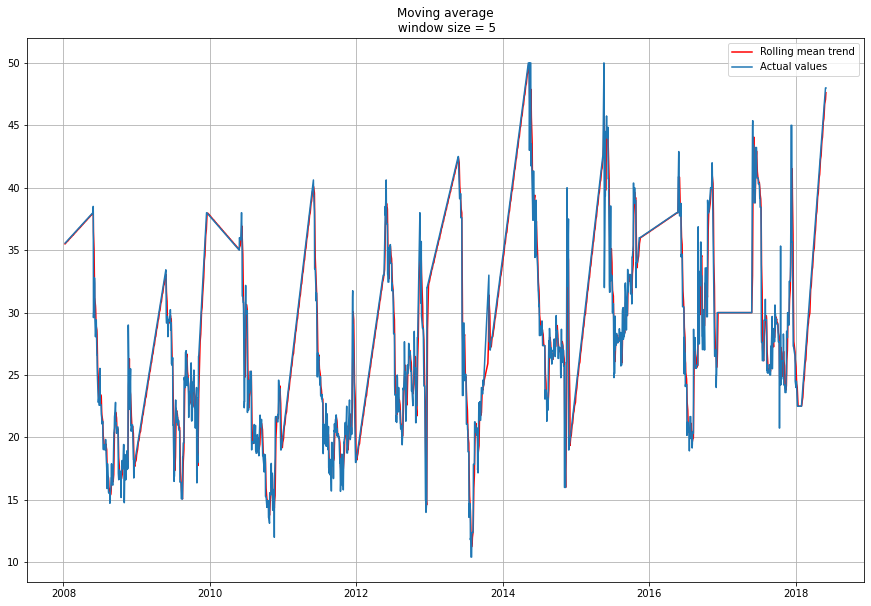

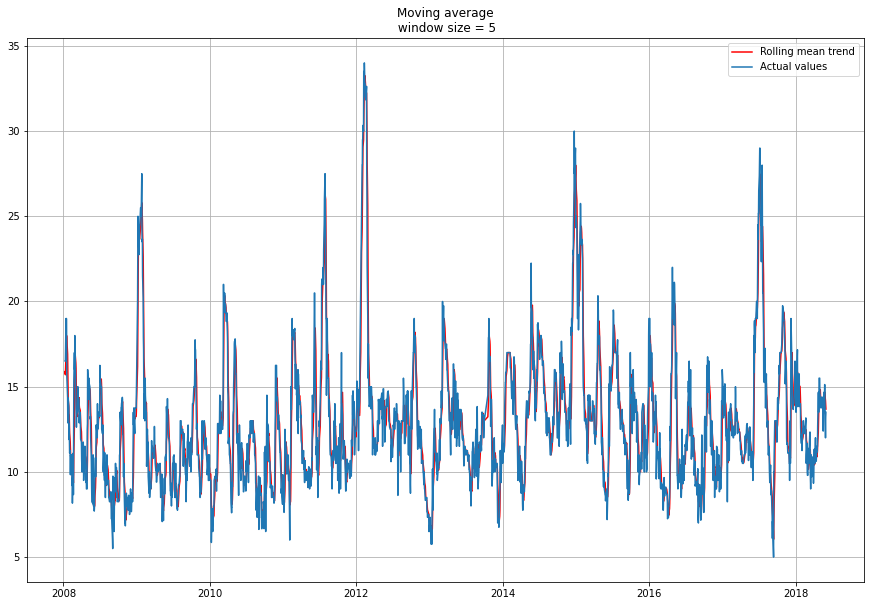

In [140]:
#Smooth by the previous 5 days (by week)
for i in col:
    print(i)
    plot_moving_average(data[i], 5)
      

price_steel
price_rebar
price_glass
price_concrete
price_plywood


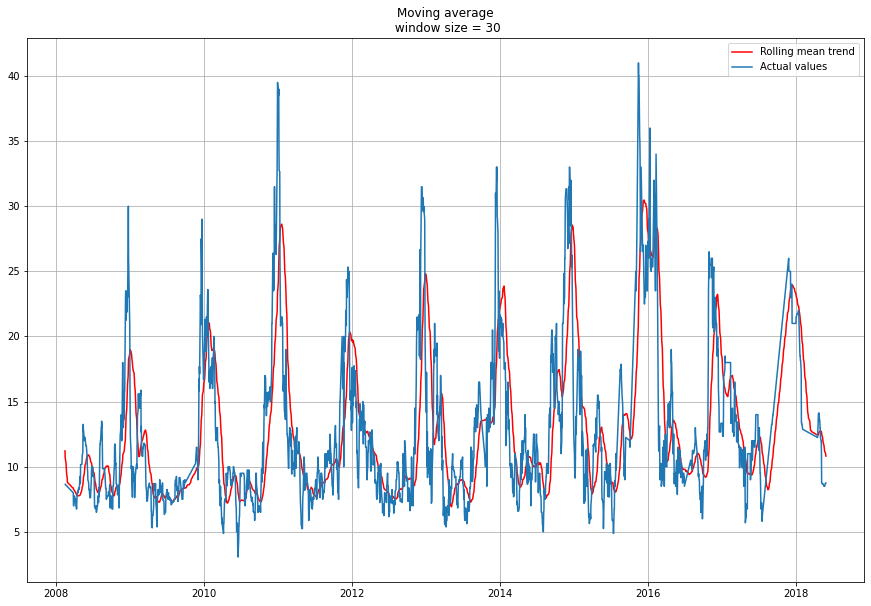

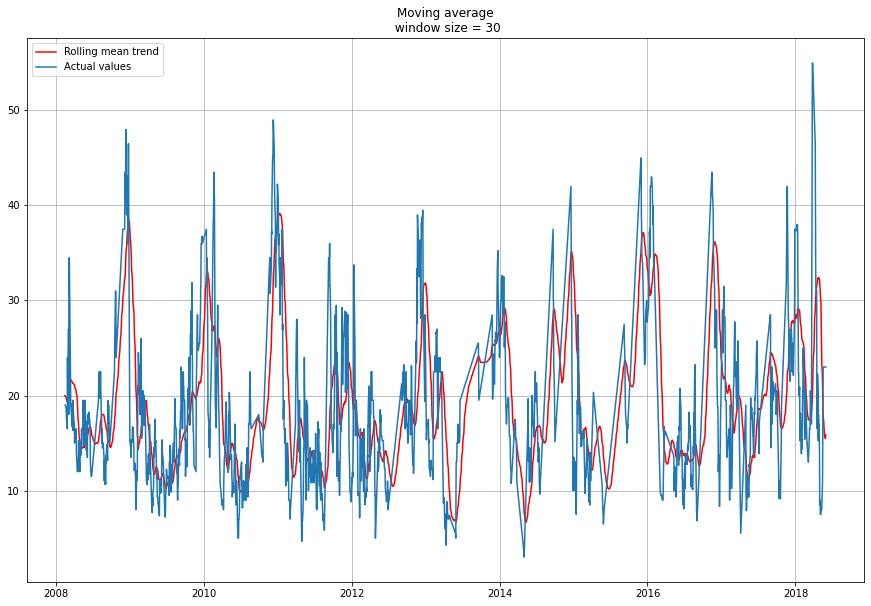

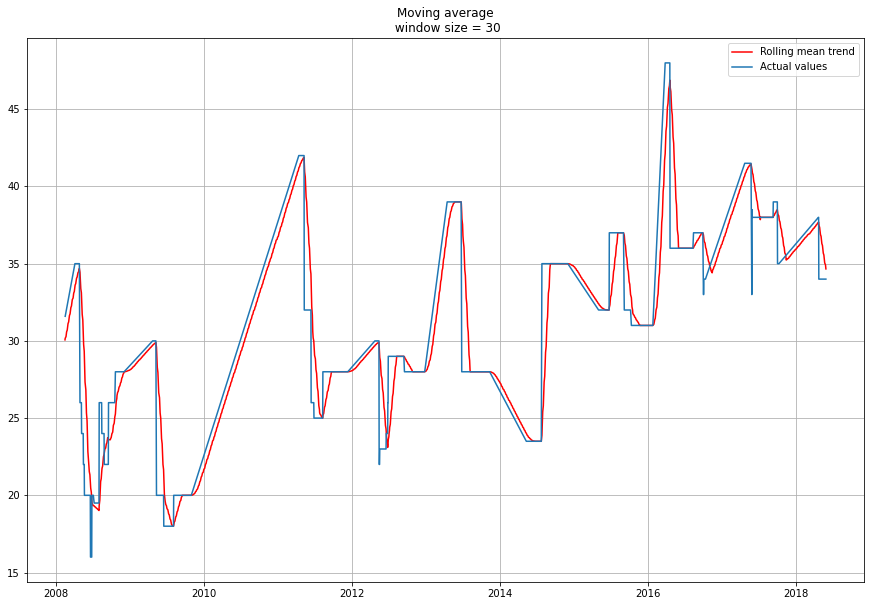

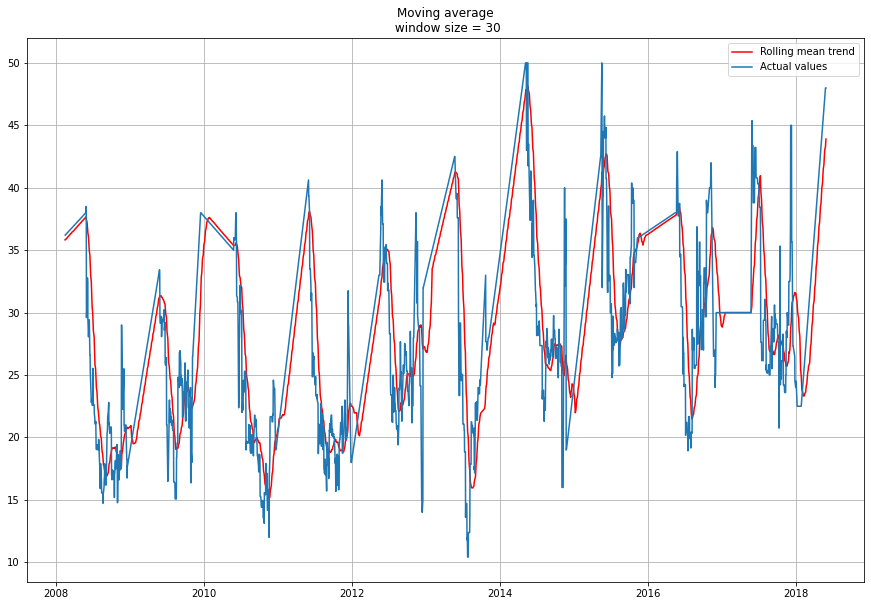

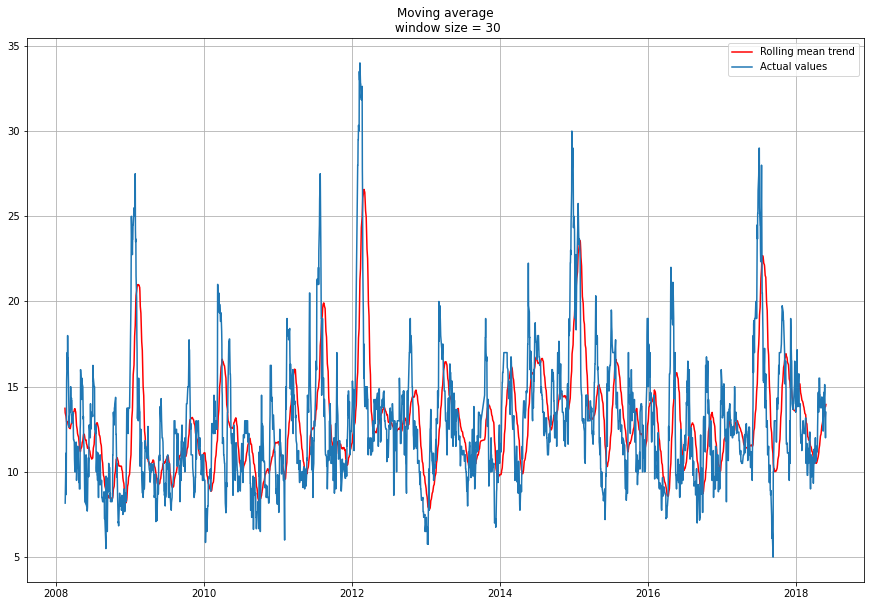

In [141]:
#Smooth by the previous month (30 days)
for i in col:
    print(i)
    plot_moving_average(data[i], 30)

price_steel
price_rebar
price_glass
price_concrete
price_plywood


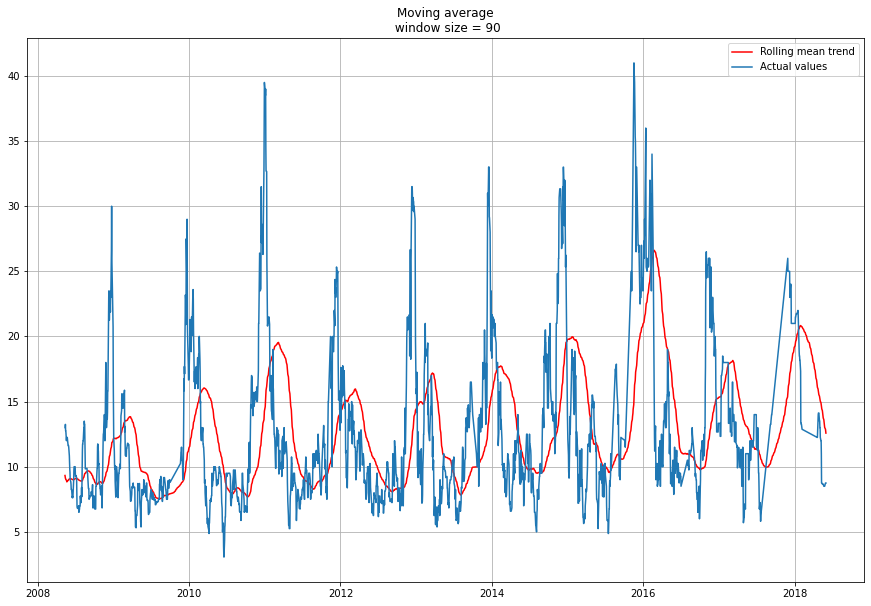

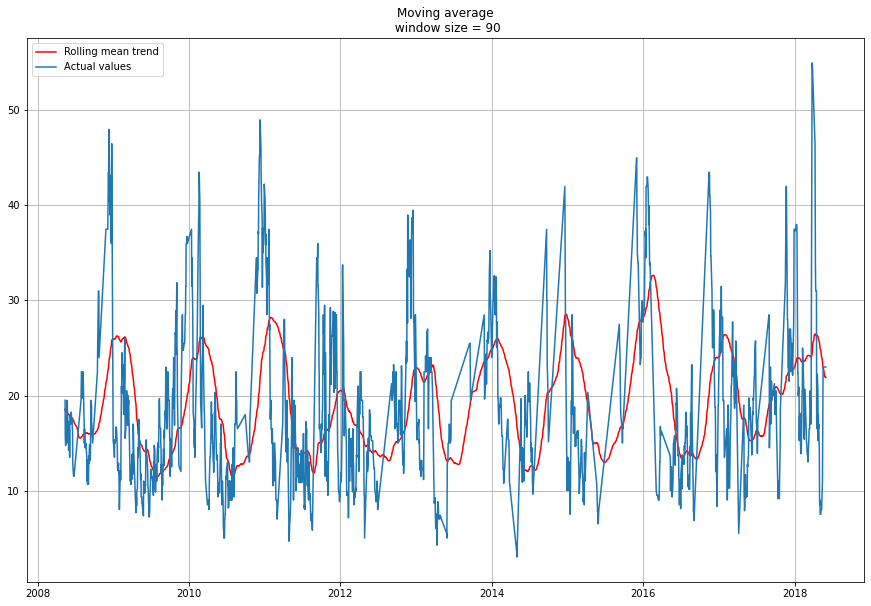

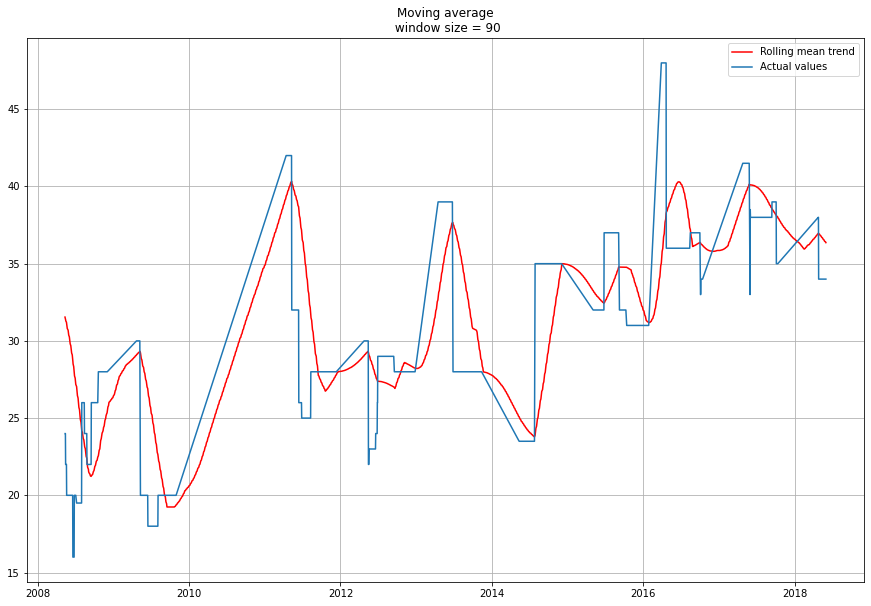

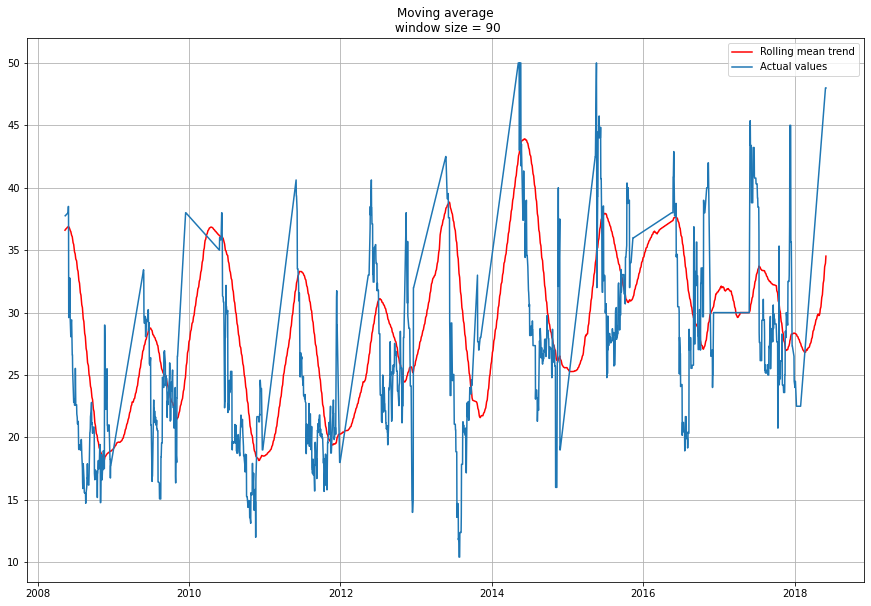

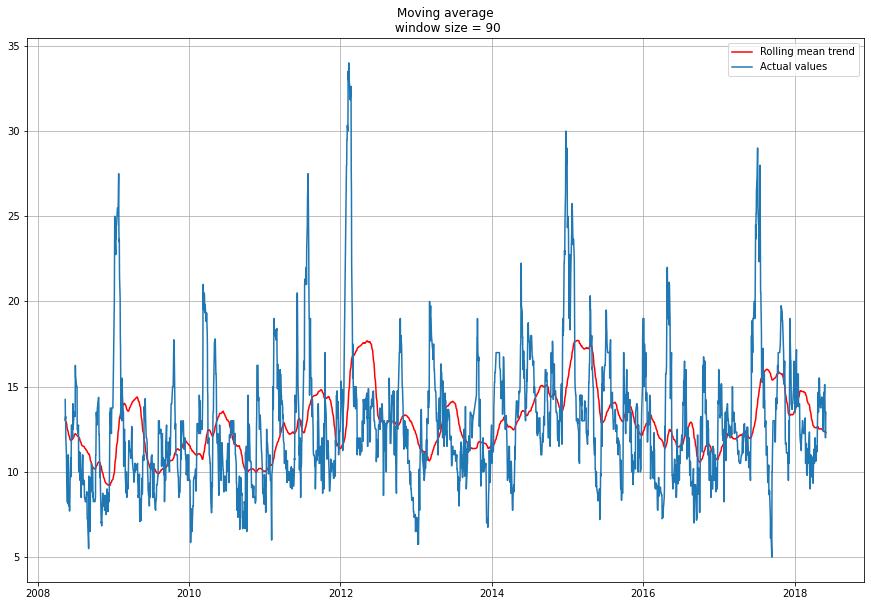

In [142]:
#Smooth by previous quarter (90 days)
for i in col:
    print(i)
    plot_moving_average(data[i], 90)

# Price correlation

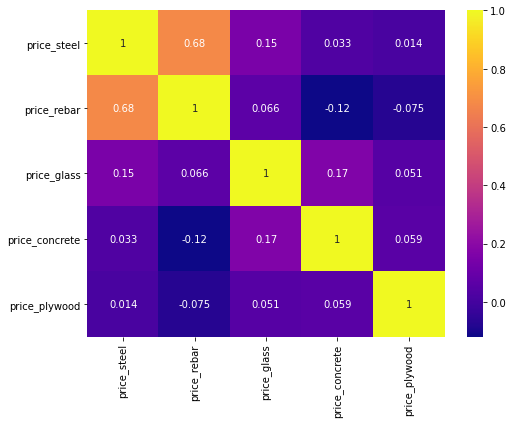

In [121]:
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,6))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="plasma")
# plt.savefig("correlation_matrix")

Rebar seems to be highly correlated with steel and glass prices. Concrete has a correlation with plywood. Don't know how this information might be useful. For now, it's good to understand the data.

#  Check weekly, monthly, daily trend

In [143]:
#Extracting year, month and day
data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])
data["year"]=data['Date'].dt.year
data["month"]=data["Date"].dt.month
data["day"]=(data["Date"]).dt.day
data.head()

Date  price_steel  price_rebar  price_glass  price_concrete  \
0 2008-01-03        24.45    21.000000    28.538462       35.449074   
1 2008-01-04        20.65    20.953125    28.609467       35.466667   
2 2008-01-07        16.00    20.812500    28.822485       35.519444   
3 2008-01-08        19.00    20.765625    28.893491       35.537037   
4 2008-01-09        15.75    20.718750    28.964497       35.554630   

   price_plywood  year  month  day  
0           16.0  2008      1    3  
1           17.5  2008      1    4  
2           12.5  2008      1    7  
3           16.5  2008      1    8  
4           16.5  2008      1    9

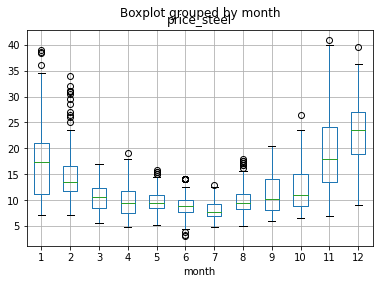

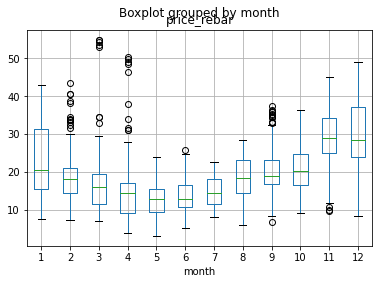

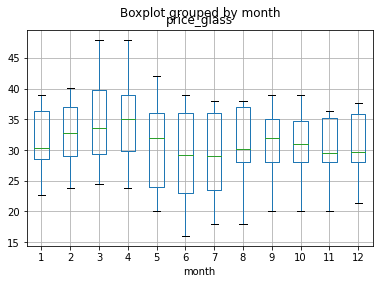

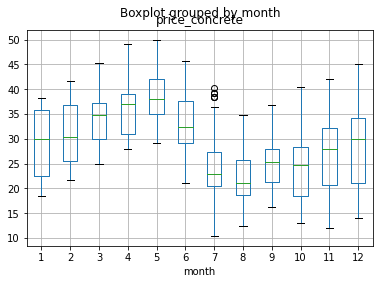

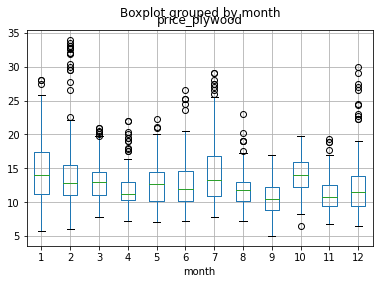

In [159]:
#Boxplot to see monthly trends
col=["price_steel","price_rebar","price_glass", "price_concrete","price_plywood"]
for i in col:  
    ax = data.boxplot(column=[i], by='month')


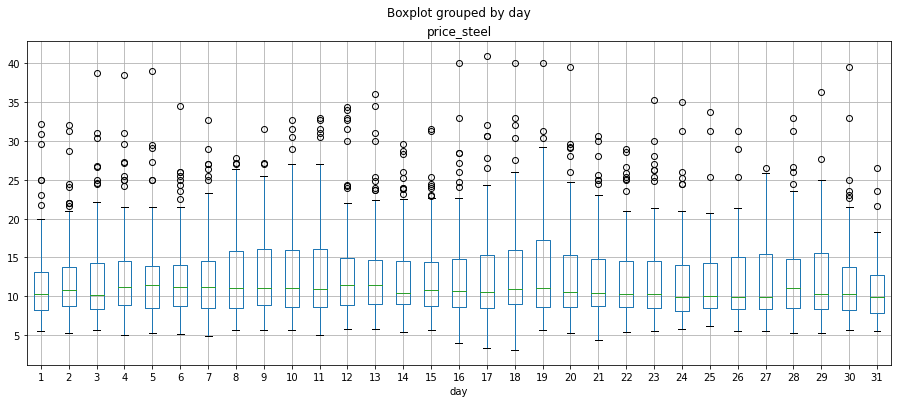

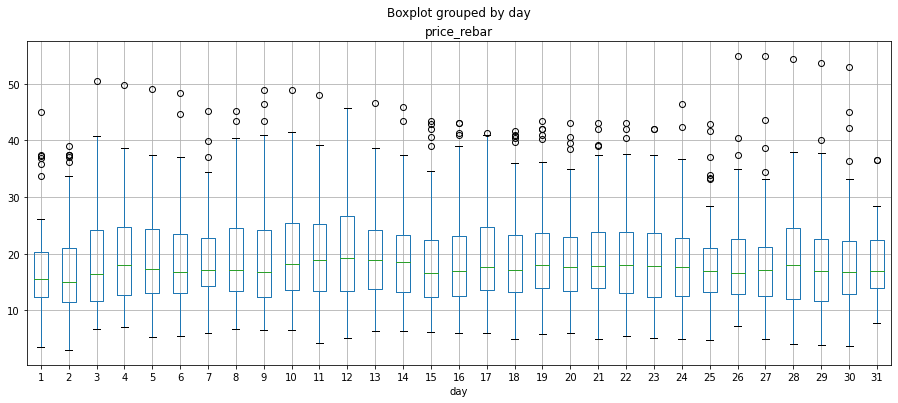

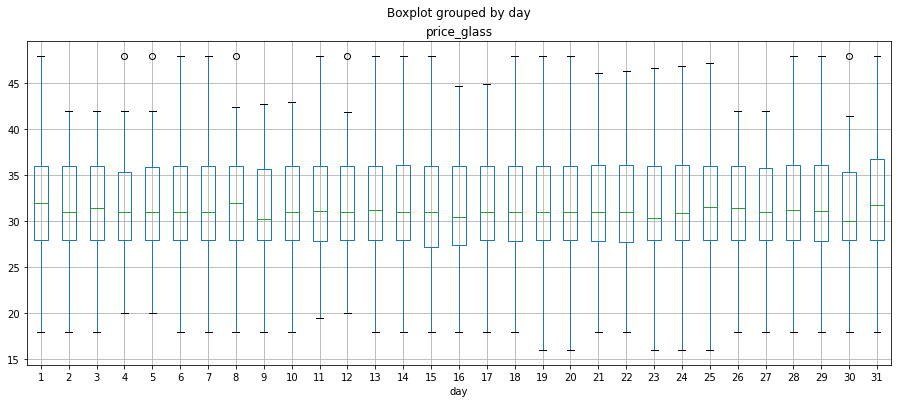

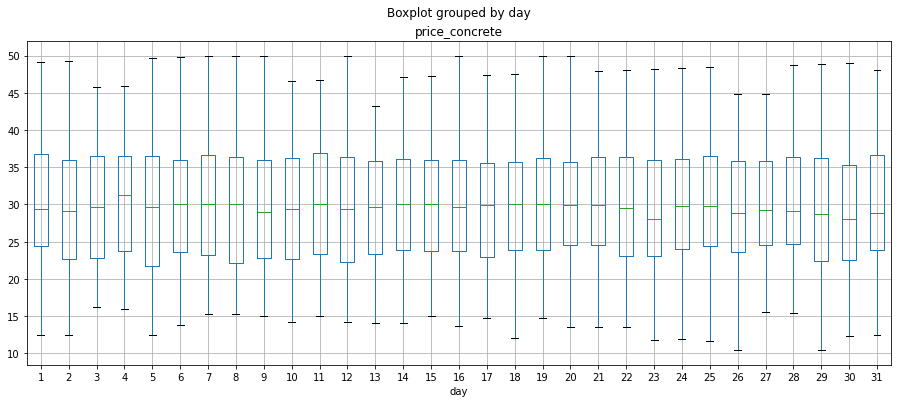

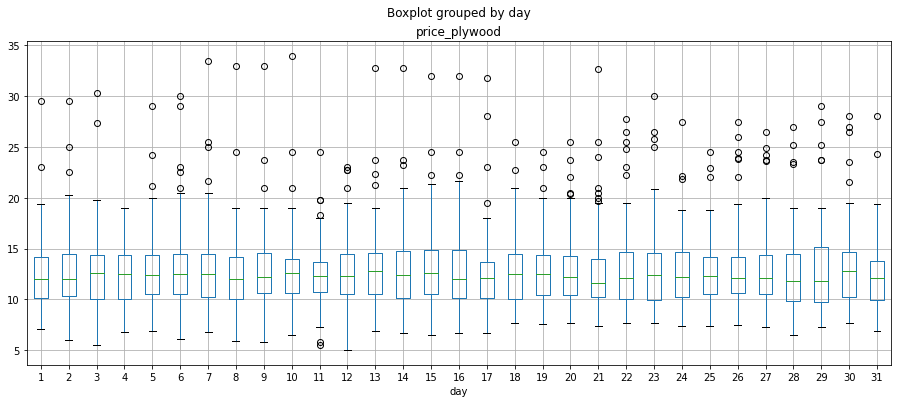

In [161]:
#Boxplot to see daily trends
col=["price_steel","price_rebar","price_glass", "price_concrete","price_plywood"]
for i in col:  
    ax = data.boxplot(column=[i], by='day')

No specific pattern could be seen on daily prices

## Check for stationarity:

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time and an autocovariance that does not depend on time. Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 

Using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package to check for stationarity. The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

In [62]:
#Check for stationarity:
from statsmodels.tsa.stattools import adfuller
from numpy import log
col=data.columns
for i in col:
    print(i)
    result = adfuller(data[i].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

price_steel
ADF Statistic: -5.902017
p-value: 0.000000
price_rebar
ADF Statistic: -8.023105
p-value: 0.000000
price_glass
ADF Statistic: -2.902649
p-value: 0.045041
price_concrete
ADF Statistic: -4.522579
p-value: 0.000179
price_plywood
ADF Statistic: -9.786105
p-value: 0.000000


Since p-value is less than the significance level (0.05), we reject the null hypothesis. Hence, data is stationary. So, no differencing is required.

# Modeling using prophet

In [209]:
from fbprophet import Prophet
import logging

In [162]:
#Since data for price of plywood is pretty clean with 2.27% missing values, I will first drop the values and make forecast for the next 6 months
new=data.reset_index()
plywood=new[["Date", "price_plywood"]]
# plywood=plywood.dropna()
plywood=plywood.rename(columns={"Date": "ds", "price_plywood": "y"})
plywood

ds       y
0    2008-01-03  16.000
1    2008-01-04  17.500
2    2008-01-07  12.500
3    2008-01-08  16.500
4    2008-01-09  16.500
...         ...     ...
2586 2018-05-24  14.600
2587 2018-05-25  15.125
2588 2018-05-29  12.000
2589 2018-05-30  13.200
2590 2018-05-31  13.500

[2591 rows x 2 columns]

In [163]:
#Split data
prediction_size = 30
train_df = plywood[:-prediction_size]
train_df

ds          y
0    2008-01-03  16.000000
1    2008-01-04  17.500000
2    2008-01-07  12.500000
3    2008-01-08  16.500000
4    2008-01-09  16.500000
...         ...        ...
2556 2018-04-12  10.625000
2557 2018-04-13  10.625000
2558 2018-04-16  11.500000
2559 2018-04-17  11.166667
2560 2018-04-18  11.500000

[2561 rows x 2 columns]

In [174]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline
m = Prophet()
m.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [175]:
#Predicting the values for the future (6 months=180 days)
future = m.make_future_dataframe(periods=180)
forecast = m.predict(future)

### Plot the forecast and its components

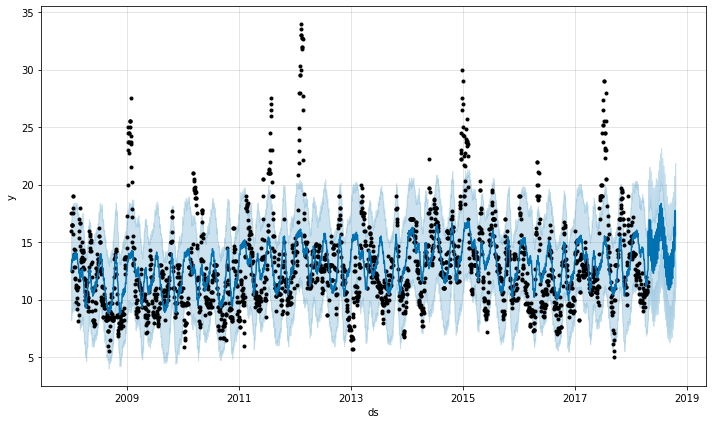

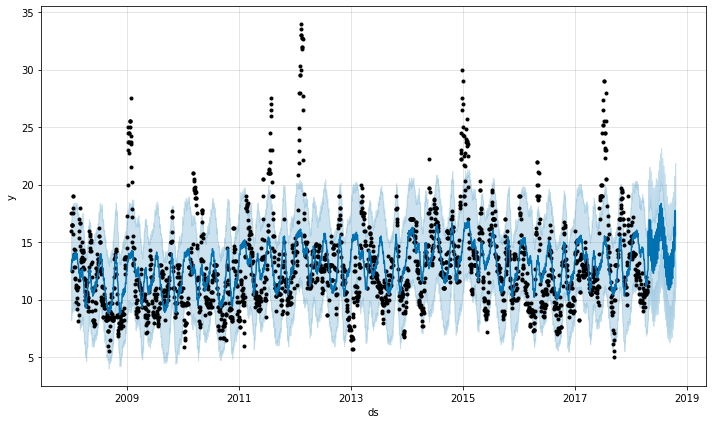

In [176]:
#plot the predicted data
m.plot(forecast)

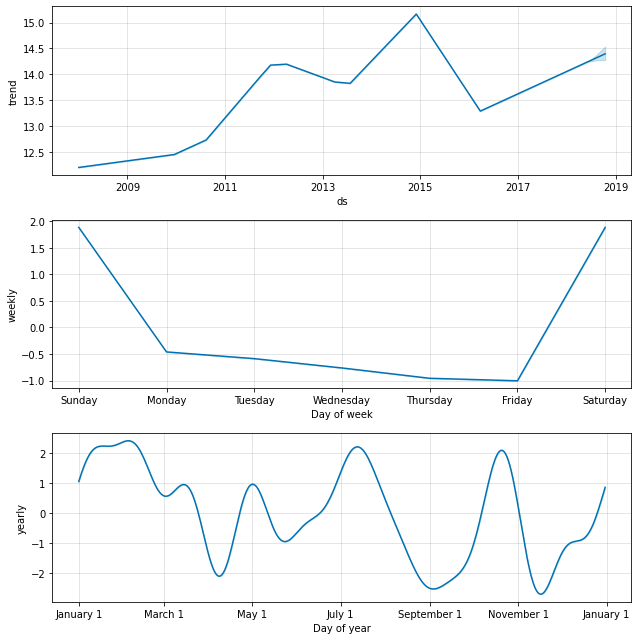

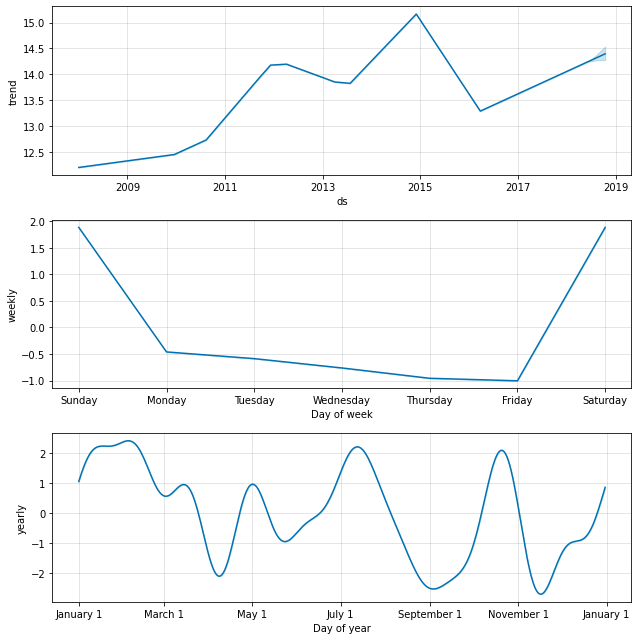

In [177]:
#Plotting the forecasted components to check trend and seasonality
m.plot_components(forecast)

The price of plywood seems to be increasing over the next 6 months as observed from the plot of forecast component